In [4]:
# Import Libraries
import tensorflow as tf
import os
import glob
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Input, BatchNormalization, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Import libraries for evaluation
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import average_precision_score

In [5]:
# Load and Resize Images
folder_path = "D:\\ML Datasets\\ISEF_24-25_Pharyngitis\\Mendeley&Kaggle Pharyngitis Dataset"
files_list = glob.glob(os.path.join(folder_path, '**', '*.jpg'), recursive=True)

images, labels12 = [], []
for file in files_list:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    resized_image = cv2.resize(image, (64, 64))
    images.append(resized_image)
    dirname = os.path.dirname(file)
    labels12.append(os.path.basename(dirname))

images = np.array(images, dtype='float32') / 127.5 - 1
labels = np.array(labels12, dtype=str)

In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(y_train))
print(len(X_train))

561
561


In [18]:
# Encode Labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)
print(f"Number of Classes: {num_classes}")

Number of Classes: 2


In [20]:
# (Fake Images) with Random Transformations

def augment_image(image):
    choice = random.choice(['blur', 'brightness', 'contrast', 'rotate'])
    if choice == 'blur':
        kernel_size = random.choice([3, 5])
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    elif choice == 'brightness':
        factor = random.uniform(0.8, 1.2)
        return np.clip(image * factor, -1, 1)
    elif choice == 'contrast':
        factor = random.uniform(0.8, 1.2)
        mean = np.mean(image)
        return np.clip((image - mean) * factor + mean, -1, 1)
    elif choice == 'rotate':
        angle = random.uniform(-10, 10)
        height, width = image.shape[:2]
        matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
        return cv2.warpAffine(image, matrix, (width, height), borderMode=cv2.BORDER_REFLECT)
    return image

# Apply Augmentation to Dataset
X_train_augmented = np.array([augment_image(img) for img in X_train])
X_test_augmented = np.array([augment_image(img) for img in X_test])

<h1>CycleGAN code START<h1>

In [ ]:
# Building the Generator
def build_generator():
    inputs = Input(shape=(64, 64, 3))
    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (4, 4), strides=2, padding='same')(x)
    outputs = Conv2D(3, (3, 3), padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

"\nLine-by-Line Breakdown:\n\nInput(shape=(64, 64, 3)):\n\nSpecifies the input shape of the generator. Images are 64x64 pixels with 3 color channels (RGB).\nConv2D(64, (4, 4), strides=2, padding='same')(inputs):\n\nApplies a 2D convolution with 64 filters, a 4x4 kernel, and a stride of 2.\nStride reduces the spatial dimensions by half, effectively downsampling the input.\nLeakyReLU(alpha=0.2)(x):\n\nApplies the LeakyReLU activation function with a slope of 0.2 for negative values.\nBatchNormalization()(x):\n\nNormalizes the layer’s output to stabilize training and speed up convergence.\nConv2DTranspose(64, (4, 4), strides=2, padding='same')(x):\n\nPerforms transposed convolution, which upsamples the image back to its original dimensions.\ntf.keras.activations.tanh(x):\n\nApplies a tanh activation, scaling the output to the range [-1, 1].\nreturn Model(inputs, outputs):\n\nCombines all layers into a Keras Model, which represents the generator.\n"

In [ ]:
# Building the Discriminator
def build_discriminator():
    inputs = Input(shape=(64, 64, 3))
    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    outputs = Conv2D(1, (4, 4), padding='same')(x)
    return Model(inputs, outputs)

"\nLine-by-Line Breakdown:\n\nInput(shape=(64, 64, 3)):\n\nSpecifies the input shape of the discriminator (same as the generator).\nConv2D(64, (4, 4), strides=2, padding='same')(inputs):\n\nExtracts features by applying 2D convolution with 64 filters and a stride of 2.\nLeakyReLU(alpha=0.2)(x):\n\nUses LeakyReLU to handle negative values effectively.\nConv2D(128, (4, 4), strides=2, padding='same')(x):\n\nFurther extracts features with more filters (128) and downscales the input.\nConv2D(1, (4, 4), padding='same')(x):\n\nOutputs a single value per spatial location to predict whether the patch is real or fake.\nreturn Model(inputs, outputs):\n\nConstructs the discriminator model.\n"

In [ ]:
# Instantiate the models (generator and discriminator)
generator_g = build_generator()  # A -> B
generator_f = build_generator()  # B -> A
discriminator_x = build_discriminator()  # A
discriminator_y = build_discriminator()  # B

'\ngenerator_g: Translates images from Domain A to Domain B.\ngenerator_f: Translates images from Domain B to Domain A.\ndiscriminator_x: Determines if an image belongs to Domain A.\ndiscriminator_y: Determines if an image belongs to Domain B.\n'

In [ ]:
# Define Loss Functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)

# Cycle Consistency Loss
def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

# Identity Loss
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

In [ ]:
# Optimizers
gen_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

'\nAdam Optimizer: Adaptive learning rate optimizer.\n2e-4: Learning rate.\nbeta_1=0.5: Momentum term for stabilization.\n'

In [11]:
# Training CycleGAN (Simplified Loop)
def train_cyclegan_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Forward Pass
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity Mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator Outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)

        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Loss Calculation
        gen_g_loss = generator_loss(disc_fake_y) + cycle_consistency_loss(real_x, cycled_x) + identity_loss(real_y, same_y)
        gen_f_loss = generator_loss(disc_fake_x) + cycle_consistency_loss(real_y, cycled_y) + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Backpropagation
    gradients_gen_g = tape.gradient(gen_g_loss, generator_g.trainable_variables)
    gradients_gen_f = tape.gradient(gen_f_loss, generator_f.trainable_variables)
    gradients_disc_x = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    gradients_disc_y = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    gen_g_optimizer.apply_gradients(zip(gradients_gen_g, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gradients_gen_f, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(gradients_disc_x, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(gradients_disc_y, discriminator_y.trainable_variables))



In [ ]:
# CycleGAN Training
for epoch in range(50): 
    for i in range(len(X_train)):
        train_cyclegan_step(X_train_augmented[i:i+1], X_train[i:i+1])

'\nTraining Cycle: Iterates over epochs and image batches.\nGenerators: Generate fake images and cycle back to original domains.\nDiscriminators: Evaluate real and fake images.\nLoss Gradients: Calculate and apply gradients to update model weights.\n'

In [ ]:
# Generate Augmented Dataset Using CycleGAN
cycle_gan_images = generator_g.predict(X_train_augmented)
X_train_final = np.concatenate([X_train_augmented, cycle_gan_images], axis=0)
y_train_final = np.concatenate([y_train_one_hot, y_train_one_hot], axis=0)

18/18 [==============================] - 2s 92ms/step


'\ngenerator_g.predict(X_train): Generates augmented images.\nScaling Back: Converts data from [-1, 1] to [0, 255].\nConcatenation: Combines original and augmented data for training.\n'

<h1>CycleGAN code ENDS<h1>

1/1 [==============================] - 0s 131ms/step


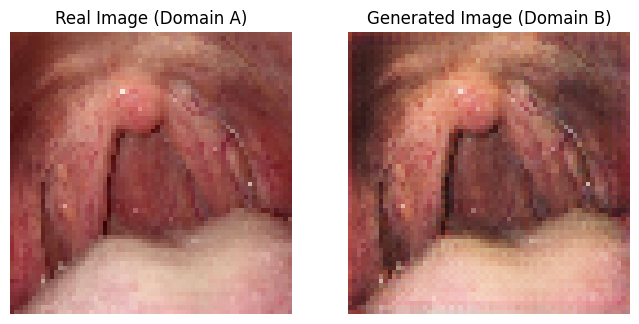

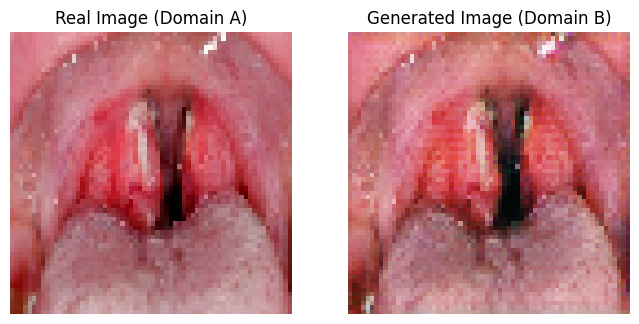

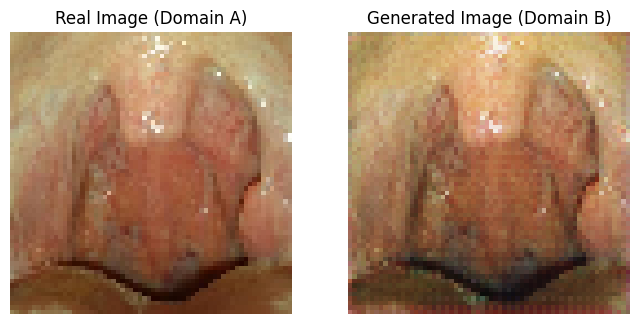

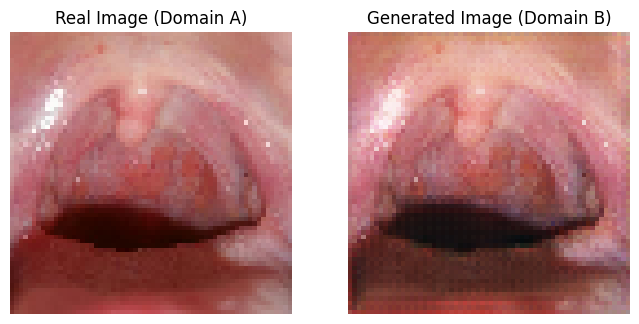

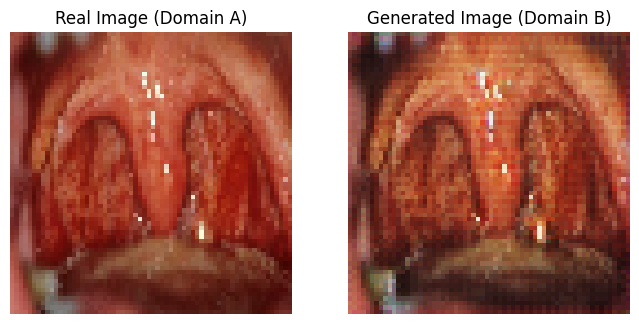

In [14]:
# Generate fake images
fake_images = generator_g.predict(X_train[:5])  # Predict using a small batch

# Plot real images vs. generated images
for i in range(len(fake_images)):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Real Image (Domain A)")
    plt.imshow((X_train[i] + 1) / 2)  # Rescale to [0, 1]
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Generated Image (Domain B)")
    plt.imshow((fake_images[i] + 1) / 2)  # Rescale to [0, 1]
    plt.axis("off")
    plt.show()


In [30]:
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(2, activation='softmax')  # Assuming 2 classes
])


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 31, 31, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                      

In [ ]:
# fit to model
#model.fit(X_train_final, y_train_final, epochs=10,batch_size=16)
# ran 4 times so 20 epochs total
model.fit(X_train, y_train_one_hot, epochs=5,batch_size=32)

Epoch 1/5
36/36 [==============================] - 2s 67ms/step - loss: 0.0296 - accuracy: 0.9911
Epoch 2/5
36/36 [==============================] - 2s 61ms/step - loss: 0.0207 - accuracy: 0.9929
Epoch 3/5
36/36 [==============================] - 2s 66ms/step - loss: 0.0465 - accuracy: 0.9911
Epoch 4/5
36/36 [==============================] - 2s 65ms/step - loss: 0.0319 - accuracy: 0.9893
Epoch 5/5
36/36 [==============================] - 2s 62ms/step - loss: 0.0211 - accuracy: 0.9929


In [34]:
# Get predicted probabilities
y_pred_prob = model.predict(X_test)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test to class labels if it's still one-hot encoded
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Calculate and print accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print('Test accuracy:', accuracy)

# Calculate and print F1 score
f1 = f1_score(y_test_labels, y_pred)
print('F1 score:', f1)

# ROC-AUC Use probabilities for the positive class
roc_auc = roc_auc_score(y_test_one_hot[:, 1], y_pred_prob[:, 1])
print('ROC-AUC score (binary):', roc_auc)

5/5 [==============================] - 0s 48ms/step
Test accuracy: 0.9574468085106383
F1 score: 0.9423076923076923
ROC-AUC score (binary): 0.9913319238900633


In [ ]:
#99.1 AUROC on plain test dataset - but generalized with image augmentations and cycleGAN
model.save("C:\\Users\\skovv\\OneDrive\\Visual Studio Code Projects\\Projects\\ISEF_Pharyngitis\\savedModels\\customCNNmodel_v2withCycleGAN.hdf5")  # Saving as .hdf5 file

C:\Users\skovv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
